In [2]:
import numpy as np
import pandas as pd
import io
import random
import itertools
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
## Read weights and costs 

data_name = 'RGP100'
weights = pd.read_excel('/content/drive/My Drive/sc1-data/' + data_name + '_flow.xlsx', header=None)
costs = pd.read_excel('/content/drive/My Drive/sc1-data/' + data_name + '_cost.xlsx', header=None)

weights.index = range(1, len(weights.index)+1)
weights.columns = range(1, len(weights.columns)+1)
costs.index = range(1, len(costs.index)+1)
costs.columns = range(1, len(costs.columns)+1)

#CAB25:  n = 25,  p = 3,5
#TR55:   n = 55,  p = 3,5
#TR81:   n = 81,  p = 5,7
#RGP100: n = 100, p = 7,10

n = 100
p = 7

In [4]:
## Generate random candidate solution

def generate_candidate(n,p):

  hubs = random.sample(range(1, n+1), p) 
  solution = [ni if ni in hubs else random.choice(hubs) for ni in range(1,n+1)]

  return solution

In [5]:
## Generate discrete population of candidate solutions

def generate_population(n,p,size):
  
  pop = []

  for i in range(size):
    pop.append(generate_candidate(n,p))

  return pop


In [6]:
## Calculate net cost for flow between hubs

def total_flow_cost(flow_sum):

  slope = 0
  intercept = 0
  check = flow_sum/1000

  if   0<=check<50:     slope = 1.0; intercept = 0
  elif 50<=check<100:   slope = 0.8; intercept = 10000
  elif 100<=check<200:  slope = 0.6; intercept = 30000
  elif 200<=check:      slope = 0.4; intercept = 70000

  return slope*flow_sum + intercept

In [7]:
## Model the hubs-and-nodes network as a dictionary

def network(candidate):

  hubs = set(candidate)
  candidate = np.array(candidate)
  network = {h:list(np.where(candidate == h)[0]+1) for h in hubs}

  return network

In [8]:
def network_flow(network):

  network_flow = {}

  for k in network:
    for m in network:

      if(k==m): network_flow[(k,m)]=0
      else:
        nodes_at_k = network[k]
        nodes_at_m = network[m]
        nodes_pairs = list(itertools.product(nodes_at_k, nodes_at_m))
        
        flow_sum = sum([weights[kk][mm] for (kk,mm) in nodes_pairs])
        flow_cost = total_flow_cost(flow_sum)
        network_flow[(k,m)] = flow_cost*costs[k][m]

  return network_flow

In [9]:
## Calculate total cost (fitness) of a candidate

def total_cost(candidate):

  total_cost = 0

  for i in range(len(candidate)):
    for j in range(len(candidate)):
      node_i = i+1
      node_j = j+1
      hub_k = candidate[i]
      hub_m = candidate[j]

      total_cost += weights[node_i][node_j]*(costs[node_i][hub_k] + costs[hub_m][node_j])

  hub_network = network(candidate)
  for k in hub_network:
    for m in hub_network:

      if(k!=m): 
        nodes_at_k = hub_network[k]
        nodes_at_m = hub_network[m]
        nodes_pairs = list(itertools.product(nodes_at_k, nodes_at_m))
        
        flow_sum = sum([weights[kk][mm] for (kk,mm) in nodes_pairs])
        flow_cost = total_flow_cost(flow_sum)

        total_cost += flow_cost*costs[k][m]

  return total_cost

In [10]:
## Tournament selection

def selection(population, fitnesses, T_size):

  tournament = random.sample(range(len(population)), T_size)

  winner_ind = tournament[0]
  for t_ind in tournament[1:]:
    if fitnesses[t_ind] > fitnesses[winner_ind]:
      winner = t_ind

  #return the winning candidate
  return population[winner_ind]

In [11]:
## Crossover 3

def crossover3(parent1, parent2, p):

  n = len(parent1)
  parents = [parent1,parent2]
  sets = set(parent1).union(set(parent2))
  children = [[None]*n,[None]*n]

  for child in children:

    #allocating hubs
    hubs = random.sample(sets, p)
    for h in hubs:
      child[h-1] = h
    
    #allocating nodes to hubs
    for i in range(n):
      if (child[i]==None):

        ind = random.randint(0, 1)
        node1 = parents[ind][i]
        node2 = parents[ind^1][i]

        if (node1 in set(child)):
          child[i] = node1
        elif (node2 in set(child)):
          child[i] = node2

    #repairing unallocated nodes
    for i in range(n):
      if (child[i]==None):
        hubs = set(child)
        hubs.remove(None)
        child[i] = random.choice(tuple(hubs))
      

  return children[0], children[1]

In [13]:
## Mutation

def mutation(candidate, mr):

  hubs = set(candidate)

  for i in range(len(candidate)):
    hub_i = candidate[i]
    node_i = i+1

    if node_i != hub_i:
      if random.random() < mr:
        hubs.remove(hub_i)
        candidate[i] = random.choice(tuple(hubs))
        hubs.add(hub_i)

  return candidate

In [15]:
## Elitism

def elitism(population,fitnesses,num_elite):

  zipped = zip(population,fitnesses)
  ranked = sorted(zipped, key=lambda x: x[1])
  candidates = [c for (c,_) in ranked]
  elites = candidates[:num_elite]
  pop = [c for c in population if c not in elites]
  #print(population)
  #print(elites)
  #pop = set(population) - set(elites)

  return elites, pop

In [17]:
## PROGRAM RUN

def model_2(n,p,time_steps,pop_size,mr,elite_size,T_size):

  #generate initial population
  population = generate_population(n,p,pop_size)
  fitnesses = []

  best_fs = []
  best_cs = []

  for t in range(time_steps):

    #termination criteria
    if len(best_fs)>=30:
      if sum(np.diff(best_fs[-30:])) == 0:
        break

    #fitness evaluation
    fitnesses = [total_cost(candidate) for candidate in population]
    best_fitness = min(fitnesses)
    best_candidate = population[np.argmin(fitnesses)]
    best_fs.append(best_fitness)
    best_cs.append(best_candidate)

    if len(best_fs)%15 == 0 and elite_size>=4:
      if sum(np.diff(best_fs[-15:])) == 0:
        elite_size -= int(elite_size*0.2)

    #separating elites
    elites, pop = elitism(population,fitnesses,elite_size)
    elite_parents = random.sample(elites, elite_size//2)

    #selection
    selected =  elite_parents + [selection(pop, fitnesses, T_size=T_size) for _ in range(pop_size-len(elites)-len(elite_parents))]
    new_population = []

    #crossover and mutation
    for i in range(0, pop_size-len(elites), 2):
      
      if len(selected)<2:
        for i in range(2-len(selected)):
          selected = selected.append(mutation(selected[0],mr))
          print(selected)
      
      randoms = random.sample(selected, 2)
      selected.remove(randoms[0])
      selected.remove(randoms[1])
      child1, child2 = crossover3(randoms[0],randoms[1],p)
      child1 = mutation(child1,mr)
      child2 = mutation(child2,mr)

      new_population.append(child1)
      new_population.append(child2)

    #update population
    population = elites + new_population

    #print("Iteration {}: Best Fitness = {}, Best Individual = {}".format(t, best_fitness, best_candidate))

  return best_fs, best_cs

In [122]:
best_fs, best_cs = model_2(n=10,p=3,time_steps=100,pop_size=150,mr=0.8,elite_size=10,T_size=20)
#print(best_fs)
#print(best_cs)

In [ ]:
## Experiment with Mutation Rates

best_fitnesses_mrs = []
best_candidates_mrs = []
mrs = np.arange(0.1,1,0.1)

for mr in mrs:

  best_fs, best_cs = model_2(n=10,p=3,time_steps=50,pop_size=100,mr=mr,elite_size=10,T_size=20)
  best_fitnesses_mrs.append(min(best_fs))
  best_candidates_mrs.append(best_cs[np.argmin(best_fs)])

  print("Mutation Rate {}: Best Fitness = {}, Best Individual = {}".format(mr, best_fitnesses_mrs[-1], best_candidates_mrs[-1]))


In [ ]:
min_fs = min(best_fitnesses_mrs)
min_fs_mr = mrs[np.argmin(best_fitnesses_mrs)]

plt.plot(mrs, best_fitnesses_mrs)
plt.scatter(min_fs_mr, min_fs, color = 'r')
plt.ticklabel_format(style='plain')
plt.xlabel('Mutation Rates')
plt.ylabel('Best Fitness Values')
plt.title('Mutation Rates vs Best Fitness')

In [ ]:
## Experiment with Time Steps

best_fitnesses_ts = []
best_candidates_ts = []
ts = np.arange(50,350,50)

for t in ts:

  best_fs, best_cs = model_2(n=10,p=3,time_steps=t,pop_size=100,mr=0.8,elite_size=10,T_size=20)
  best_fitnesses_ts.append(min(best_fs))
  best_candidates_ts.append(best_cs[np.argmin(best_fs)])

  print("Time Steps {}: Best Fitness = {}, Best Individual = {}".format(t, best_fitnesses_ts[-1], best_candidates_ts[-1]))


In [ ]:
min_fs = min(best_fitnesses_ts)
min_fs_ts = ts[np.argmin(best_fitnesses_ts)]

plt.plot(ts, best_fitnesses_ts)
plt.scatter(min_fs_ts, min_fs, color = 'r')
plt.ticklabel_format(style='plain')
plt.xlabel('Time Steps')
plt.ylabel('Best Fitness Values')
plt.title('Time Steps vs Best Fitness')

In [ ]:
## Experiment with Population Size

best_fitnesses_pop = []
best_candidates_pop = []
pops = np.arange(50,350,50)

for pop in pops:

  best_fs, best_cs = model_2(n=10,p=3,time_steps=50,pop_size=pop,mr=0.8,elite_size=10,T_size=20)
  best_fitnesses_pop.append(min(best_fs))
  best_candidates_pop.append(best_cs[np.argmin(best_fs)])

  print("Population Size {}: Best Fitness = {}, Best Individual = {}".format(pop, best_fitnesses_pop[-1], best_candidates_pop[-1]))

In [ ]:
min_fs = min(best_fitnesses_pop)
min_fs_pop = ts[np.argmin(best_fitnesses_pop)]

plt.plot(pops, best_fitnesses_pop)
plt.scatter(min_fs_pop, min_fs, color = 'r')
plt.ticklabel_format(style='plain')
plt.xlabel('Population Size')
plt.ylabel('Best Fitness Values')
plt.title('Population Size vs Best Fitness')

In [ ]:
## Model 2 FINAL RUN
## change problem dataset

best_fitnesses_m2 = []
best_candidates_m2 = []
time_m2 = []
compare2 = []

for i in range(6):

  best_fs, best_cs = model_2(n=100,p=10,time_steps=100,pop_size=150,mr=0.8,elite_size=10,T_size=20)

  if i==1: 
    compare2.append(best_fs)
    compare2.append(best_cs)

  best_fitnesses_m2.append(min(best_fs))
  best_candidates_m2.append(best_cs[np.argmin(best_fs)])
  time_m2.append(len(best_fs))

  print("Iteration {}: Best Fitness = {}, Best Individual = {}, Time Step = {}".format(i+1, best_fitnesses_m2[-1], best_candidates_m2[-1], time_m2[-1]))

In [27]:
min_fs = min(best_fitnesses_m2)
runs = np.arange(1,11)
min_run = runs[np.argmin(best_fitnesses_m2)]
avg_fs = np.mean(best_fitnesses_m2)
best_cs = best_candidates_m2[np.argmin(best_fitnesses_m2)]
avg_time = np.mean(time_m2)

print('Best Solution: {}'.format(str(best_cs)))
print('Best NC: {}'.format(min_fs))
print('Avg NC: {}'.format(avg_fs))
print('Avg Time: {}'.format(avg_time))

plt.plot(runs, best_fitnesses_m2)
plt.scatter(min_run, min_fs, color = 'r', label = 'Best Fitness')
plt.axhline(y=avg_fs, color='y', linestyle='--', label = 'Avg Fitness')
plt.ticklabel_format(style='plain')
plt.xticks(runs)
plt.legend()
plt.xlabel('Runs')
plt.ylabel('Best Fitness Values')
plt.title('Best Fitness in Each Run')

Best Solution: [66, 38, 73, 14, 73, 14, 66, 90, 9, 10, 73, 38, 38, 14, 14, 90, 14, 10, 9, 66, 9, 10, 90, 73, 10, 38, 73, 10, 9, 66, 10, 73, 66, 9, 14, 90, 14, 38, 66, 14, 73, 38, 9, 9, 90, 66, 9, 73, 9, 9, 90, 14, 14, 38, 14, 9, 9, 73, 73, 90, 14, 10, 73, 9, 9, 66, 66, 66, 9, 14, 73, 66, 73, 66, 90, 14, 66, 38, 9, 38, 9, 73, 90, 9, 90, 90, 66, 38, 14, 90, 10, 38, 9, 73, 14, 14, 73, 9, 14, 14]
Best NC: 156953304551.66153
Avg NC: 157947958113.36862
Avg Time: 45.5


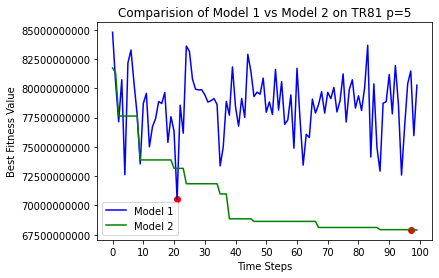

In [29]:
tr55_5_m1_fitnesses = []
tr55_5_m1_candidates = []
best_m1 = min(tr55_5_m1_fitnesses)
#candidate_m1 = tr55_5_m1_candidates[np.argmin(tr55_5_m1_fitnesses)]
m1steps = range(len(tr55_5_m1_fitnesses))

tr55_5_m2_fitnesses = []
tr55_5_m2_candidates = []
best_m2 = min(tr55_5_m2_fitnesses)
#candidate_m2 = tr55_5_m2_candidates[np.argmin(tr55_5_m2_fitnesses)]
m2steps = range(len(tr55_5_m2_fitnesses))

plt.plot(range(len(tr55_5_m1_fitnesses)), tr55_5_m1_fitnesses, color='blue', label = 'Model 1')
plt.plot(range(len(tr55_5_m2_fitnesses)), tr55_5_m2_fitnesses, color='green', label = 'Model 2')
plt.scatter(tr55_5_m1_fitnesses.index(best_m1), best_m1, color = 'r')
plt.scatter(tr55_5_m2_fitnesses.index(best_m2), best_m2, color = 'r')
plt.ticklabel_format(style='plain')
plt.xticks(np.arange(0,110,10))
plt.title('Comparision of Model 1 vs Model 2 on TR55 p=5')
plt.xlabel('Time Steps')
plt.ylabel('Best Fitness Value')
plt.legend()
plt.show()